# CityLines

## Download the dataset

Download the CSV `kaggle.com/citylines/city-lines` into a subfolder called `citylines` and unzip them.

In [1]:
ls citylines

cities.csv  station_lines.csv  systems.csv      tracks.csv
lines.csv   stations.csv       track_lines.csv


# Reading CSV files 

## Using the standard libary module csv

In [2]:
import csv

In [3]:
with open('citylines/cities.csv') as f:
    reader = csv.DictReader(f)
    cities = [line for line in reader]

In [4]:
print(len(cities))

334


## Using pandas

In [5]:
import pandas as pd
systems = pd.read_csv('citylines/systems.csv', index_col='id')
cities = pd.read_csv('citylines/cities.csv', index_col="id")
track_lines = pd.read_csv('citylines/track_lines.csv', index_col='id')
stations = pd.read_csv('citylines/stations.csv', index_col='id')
station_lines = pd.read_csv('citylines/station_lines.csv', index_col='id')
lines = pd.read_csv('citylines/lines.csv', index_col='id')
tracks = pd.read_csv('citylines/tracks.csv', index_col='id')

In [6]:
cities

,name,coords,start_year,url_name,country,country_state
id,,,,,,
5,Aberdeen,POINT(-2.15 57.15),2017.0,aberdeen,Scotland,NaN
6,Adelaide,POINT(138.6 -34.91666667),2017.0,adelaide,Australia,NaN
7,Algiers,POINT(3 36.83333333),2017.0,algiers,Algeria,NaN
9,Ankara,POINT(32.91666667 39.91666667),2017.0,ankara,Turkey,NaN
16,Belém,POINT(-48.48333333 -1.466666667),2017.0,belem,Brazil,NaN
...,...,...,...,...,...,...
265,Nantes,POINT(-1.553889 47.217222),1877.0,nantes,France,NaN
110,Stockholm,POINT(18.05 59.28333333),1919.0,stockholm,Sweden,NaN
266,Rennes,POINT(-1.680833 48.114167),1897.0,rennes,France,NaN


In [7]:
# use pandas data frame
cities['name'][16]

'Belém'

## Parsing coordinate strings

In [8]:
g = tracks['geometry'][16]
g

'LINESTRING(-58.4565034467506 -34.5622493173683,-58.4577927653747 -34.5607441036916,-58.4591937797194 -34.5591074989372,-58.4607837178131 -34.5573661677451,-58.4616310994955 -34.5564367568353,-58.4624199130135 -34.5556111854062)'

In [9]:
start, end = g.find('('), g.find(')')
start, end

(10, 226)

In [10]:
g[start+1:end]

'-58.4565034467506 -34.5622493173683,-58.4577927653747 -34.5607441036916,-58.4591937797194 -34.5591074989372,-58.4607837178131 -34.5573661677451,-58.4616310994955 -34.5564367568353,-58.4624199130135 -34.5556111854062'

In [11]:
g[start+1:end].split(',')

['-58.4565034467506 -34.5622493173683',
 '-58.4577927653747 -34.5607441036916',
 '-58.4591937797194 -34.5591074989372',
 '-58.4607837178131 -34.5573661677451',
 '-58.4616310994955 -34.5564367568353',
 '-58.4624199130135 -34.5556111854062']

In [12]:
import numpy as np
points = [[float(f) for f in pair.split(' ')]  for pair in g[start+1:end].split(',')]
np.array(points)

array([[-58.45650345, -34.56224932],
       [-58.45779277, -34.5607441 ],
       [-58.45919378, -34.5591075 ],
       [-58.46078372, -34.55736617],
       [-58.4616311 , -34.55643676],
       [-58.46241991, -34.55561119]])

### organize parsers as functions

In [13]:
def parse_linestring(geometry):
    """
    :param geometry: a string in the format "LINESTRING(x1 y1, x2 y2, ..., xn yn)"
    return numpy array of shape (n, 2) with coordinates
    """
    start = geometry.find('(')
    end = geometry.find(')')
    substring = geometry[start+1:end]
    return np.array(
        [[float(f) for f in pair.split(' ')] for pair in substring.split(',')])
    

In [14]:
parse_linestring(tracks['geometry'][2563])

array([[16.4151057, 48.1907238],
       [16.4156455, 48.190389 ],
       [16.4170845, 48.1895171]])

In [15]:
def parse_point(coords):
    """
    :param coords: a string in the form "POINT(x, y)"
    :return: [x, y] as floats
    """
    start, end = coords.find('('), coords.find(')')
    return [float(p) for p in coords[start+1:end].split(' ')]

In [16]:
cities['name'][16], parse_point(cities['coords'][16])

('Belém', [-48.48333333, -1.466666667])

### plot all cities

In [17]:
%matplotlib inline
from matplotlib import pyplot as plt

In [18]:
city_points = np.array([parse_point(p) for p in cities['coords']])

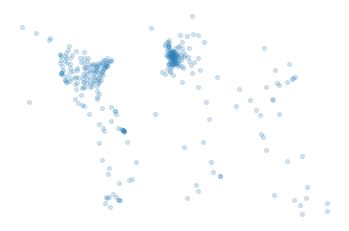

In [19]:
plt.scatter(city_points[:,0], city_points[:,1], s=16, alpha=0.2);
plt.axis(False);

### plot the transit system of a given city

In [20]:
cities

,name,coords,start_year,url_name,country,country_state
id,,,,,,
5,Aberdeen,POINT(-2.15 57.15),2017.0,aberdeen,Scotland,NaN
6,Adelaide,POINT(138.6 -34.91666667),2017.0,adelaide,Australia,NaN
7,Algiers,POINT(3 36.83333333),2017.0,algiers,Algeria,NaN
9,Ankara,POINT(32.91666667 39.91666667),2017.0,ankara,Turkey,NaN
16,Belém,POINT(-48.48333333 -1.466666667),2017.0,belem,Brazil,NaN
...,...,...,...,...,...,...
265,Nantes,POINT(-1.553889 47.217222),1877.0,nantes,France,NaN
110,Stockholm,POINT(18.05 59.28333333),1919.0,stockholm,Sweden,NaN
266,Rennes,POINT(-1.680833 48.114167),1897.0,rennes,France,NaN


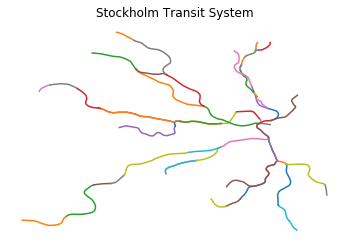

In [21]:
code = 110
name = cities['name'][code]
for line in tracks[tracks['city_id'] == code]['geometry']:
    xy = parse_linestring(line)
    plt.plot(xy[:,0], xy[:, 1])
plt.title(f'{name} Transit System')
plt.axis(False);